In [1]:
import pandas as pd
multirc_dev = pd.read_csv('../data/multirc_dev.csv', index_col=0)

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import torch
import torch.nn.functional as F
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer.pad_token = tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
def tokenize(chunk, question, answer):
    prompt = (
        "<|begin_of_text|><|start_header_id|>system<|end_header_id|>"
        "\nYou are an excellent student who has just read the following excerpt."
        " The teacher will ask you a question. You will answer accurately."
        f"\n\nExcerpt:\n\n{chunk}<|eot_id|>"
        "\n<|start_header_id|>user<|end_header_id|>"
        f"{question}<|eot_id|>"
        "\n<|start_header_id|>assistant<|end_header_id|>"
    )

    # Inputs
    # Construct inputs separately, so we know where the prompt ends.
    prompt_encoding = tokenizer(prompt, return_tensors="pt", return_length=True)
    answer_encoding = tokenizer(answer, return_tensors="pt")
    input_ids = torch.cat((prompt_encoding.input_ids, answer_encoding.input_ids), 1).to('cuda')

    # Targets
    target_ids = input_ids.clone()
    prompt_length = prompt_encoding.length.item()
    # Setting targets to -100 will ignore them when calculating loss
    # Do this for all tokens before the answer.
    target_ids[:, :prompt_length] = -100

    return input_ids, target_ids

def get_loss(input_ids, target_ids):
    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

    # loss is calculated using CrossEntropyLoss which averages over valid labels
    return outputs.loss

outputs = []

inputs = multirc_dev.sample(n=500)

test = inputs.iloc[0]
tokenize(test["source_text_clean"], test["question_text"], test["answer_text"])[1]

def assign_loss(row):
    input_ids, target_ids = tokenize(row["source_text_clean"], row["question_text"], str(row["answer_text"]))
    loss = get_loss(input_ids, target_ids)
    # print(f'Score: {cri_input["score"]} | Loss: {loss.item()}')
    return loss.item()

tqdm.pandas()
inputs['loss'] = inputs.progress_apply(lambda row: assign_loss(row), axis=1)

100%|██████████| 500/500 [03:22<00:00,  2.47it/s]


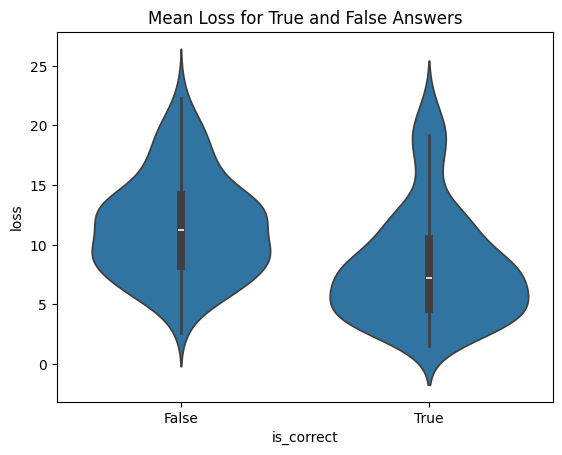

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.violinplot(inputs, x='is_correct', y='loss')
plt.title('Mean Loss for True and False Answers')
plt.show()

## Ignore after this

In [6]:
def compose_input(context, question):
    input_text = f"""
    You are a student answering a question question about a text. Please read the text and give a short answer to the question at the end. Please give the shortest answer you can.
    TEXT
    {context}

    QUESTION
    {question}

    ANSWER
    <|eot_id|>
    """
    return input_text

def find_perplexity(context, question, answer):
    # Tokenize input text and reply
    input_text = compose_input(context, question)
    reply_ids = tokenizer(input_text+answer+'<|eot_id|>', return_tensors="pt").to(device)
    # the inputs and the labels must be of the same length, for some reason
    input_ids = tokenizer(input_text, return_tensors="pt", max_length = len(reply_ids.input_ids[0]), padding="max_length").to(device)

    # Generate output logits
    outputs = model(input_ids.input_ids, labels=reply_ids.input_ids)
    logit_predictions = outputs.logits

    # Get a list of tokens and token probabilities
    tokens = []
    log_token_probs = []
    for i in range(len(logit_predictions[0,:,0])):
        # get the logits for each token
        token_logit = logit_predictions[0,i,:]
        # get log probabilities
        token_log_probs = F.log_softmax(token_logit, dim=-1)
        # look up the log probabilities for each token in the labels
        log_token_prob = token_log_probs[reply_ids.input_ids[0,i]].item()
        # append the token and the probabilities to the list
        tokens.append(tokenizer.decode(reply_ids.input_ids[0,i]))
        log_token_probs.append(log_token_prob)

    # Turn it into a dataframe
    df = pd.DataFrame({'tokens':tokens, 'log_token_probs':log_token_probs})

    # Get the probability of the answer
    mean_prob = df.iloc[df[df['tokens']=='<|eot_id|>'].index[0]+1:].log_token_probs.sum()
    return mean_prob

In [7]:
from tqdm import tqdm
tqdm.pandas()
multirc_dev_sample = multirc_dev.sample(n=500)

multirc_dev_sample['answer_prob'] = multirc_dev_sample.progress_apply(lambda row: find_perplexity(context = row['source_text_clean'],
                                                                                    question = row['question_text'],
                                                                                    answer = row['answer_text']), axis=1)

100%|██████████| 500/500 [03:49<00:00,  2.18it/s]


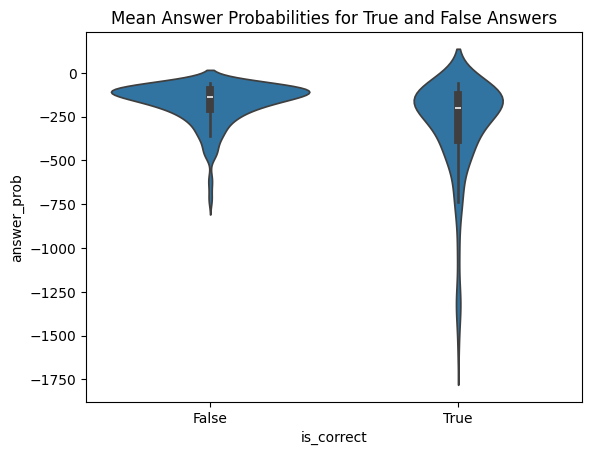

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.violinplot(multirc_dev_sample, x='is_correct', y='answer_prob')
plt.title('Mean Answer Probabilities for True and False Answers')
plt.show()

Looks like true answers have slightly lower probabilities than false answers. Results aren't great!